In [4]:
%pip install selenium

  Using cached selenium-4.7.2-py3-none-any.whl (6.3 MB)
  Using cached trio_websocket-0.9.2-py3-none-any.whl (16 kB)
  Using cached trio-0.22.0-py3-none-any.whl (384 kB)
  Using cached async_generator-1.10-py3-none-any.whl (18 kB)
  Using cached outcome-1.2.0-py2.py3-none-any.whl (9.7 kB)
  Using cached exceptiongroup-1.0.4-py3-none-any.whl (14 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl (24 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
Note: you may need to restart the kernel to use updated packages.


# WEB SCARPING


the next lines of code are the way that i used web scraping with selenium to build a dataframe of comments of the empire state building on trip advisor

In [11]:

import pandas as pd
from selenium import webdriver
from time import sleep
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

url1="https://www.tripadvisor.com/Attraction_Review"
url2="-g60763-d104365-Reviews-Empire_State_Building-New_York_City_New_York.html"

stars=[]
reviews_text=[]
reviews_title=[]
nlp_grade=[]

def scraping(url):
    driver = webdriver.Firefox()
    avg_stars=-1
    driver.get(url)
    sleep(5)
    #if you want to skip to the next page and not to open and close the driver you can use this
    #button_next =  driver.find_elements(by='css selector', value='a.BrOJk.u.j.z._F.wSSLS.tIqAi.unMkR')
    #if(len(button_next)==1):
        #url=button_next[0].get_attribute('href')
    #else:
        #url=button_next[1].get_attribute('href')

    #getting reviews titles and content
    reviews_snippets = driver.find_elements(by='css selector', value="span[class=yCeTE]")
    stars_snippets = driver.find_elements(by='css selector', value='svg.UctUV.d.H0')


    for snippet in stars_snippets:

        if(snippet.get_attribute('aria-label')!=""):
            if (avg_stars == -1):
                avg_stars = snippet.get_attribute('aria-label').split(' ')[0]
            else:
                # Extract the float number from the string
                num = snippet.get_attribute('aria-label').split(' ')[0]
                stars.append(num)

    #switching between title and text:
    flag=0


    for i in reviews_snippets:
        if(i.text!="" and not "Tickets from" in i.text):
            if(flag==0):
                reviews_title.append(i.text)
                flag=1
            else:
                reviews_text.append(i.text)
                # Get the sentiment scores for the sentence
                nlp_grade.append(analyzer.polarity_scores(i.text)['compound']*2+3)
                flag = 0
    driver.close()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\IMOE001\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
scraping(f"{url1}{url2}")
for i in range(1,1500):
    try:
        index = f"-or{i}0"
        scraping(f"{url1}{index}{url2}")
    except:
        print(f"missing page {i}")

In [121]:
import pandas as pd
from selenium import webdriver
from time import sleep
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
df = pd.read_csv('reviews.csv')

# saving the dataframe so we dont need to webscrap everytime we use this program

In [ ]:

df = pd.DataFrame({"reviews-title": reviews_title,"reviews-text":reviews_text, "stars": stars,"nlp-grade":nlp_grade})
df.to_csv('reviews.csv')
print(df)

# ploting and deleting outliers

this next plot is the total nlp score for each star rate 

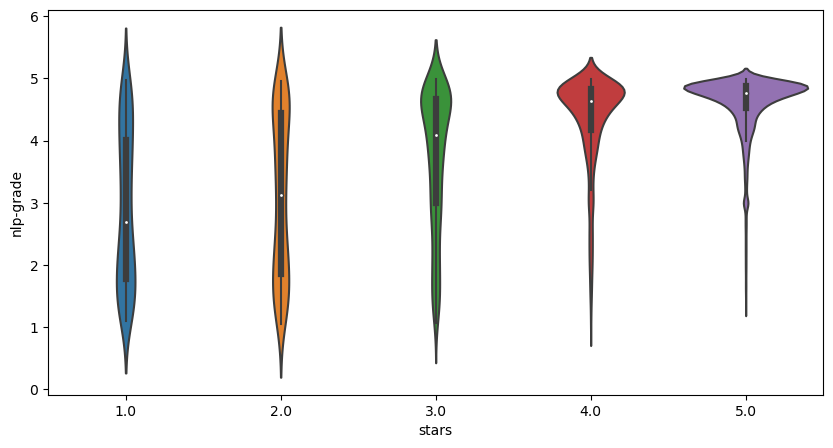

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
df = df.sort_values(by='stars', ascending=False)
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="stars", y="nlp-grade")
plt.show()

this next plot show that there is a connection between the stars grade and the nlp score

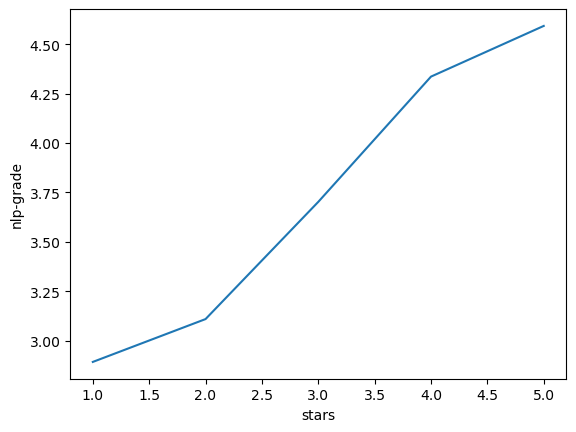

In [126]:
sums=[0,0,0,0,0]
counters = [0,0,0,0,0]
avg=[0,0,0,0,0]
for row in range(df.shape[0]):
    sums[int(float(df['stars'][row]))-1]+=df['nlp-grade'][row]
    counters[int(float(df['stars'][row]))-1]+=1
for i in range(len(sums)):
    avg[i]=sums[i]/counters[i]
plt.plot([1,2,3,4,5],avg)
plt.ylabel('nlp-grade')
plt.xlabel('stars')
plt.show()

# deleting outliers

In [117]:
import numpy as np
df['stars']=df['stars'].astype(float)
pd.options.mode.chained_assignment = None
for i in range(1,6):
    df1=df[df['stars'] == float(i)].copy()
    numer = df1.select_dtypes(include = np.number)
    for col in numer:
        Q1 = np.percentile(df1[col],25)
        Q3 = np.percentile(df1[col],75)
        IQR=Q3-Q1
        df1[''+col][(df[col]<Q1 - 2*IQR)| (df[col]>Q3 + 2*IQR)]=np.nan
    if(i==1):
        df2 = df1.copy()
    else:
        df2 = pd.concat([df1, df2], ignore_index=True)

# checking for duplicates

In [108]:
print(df.duplicated(keep='first').sum())

0


In [109]:
if(df.duplicated(keep='first').sum()>=0):
    df = df.drop_duplicates(keep='first').copy()
print(df.duplicated(keep='first').sum())

0


# deleting nulls

In [110]:
df2= df2.dropna(axis=0)
df=df.dropna(axis=0)

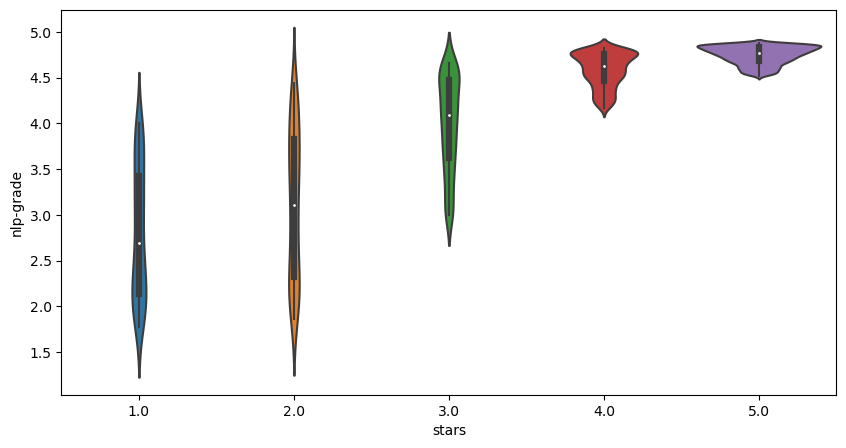

In [115]:
df2 = df2.sort_values(by='stars', ascending=False)
plt.figure(figsize=(10, 5))
sns.violinplot(data=df2, x="stars", y="nlp-grade")
plt.show()

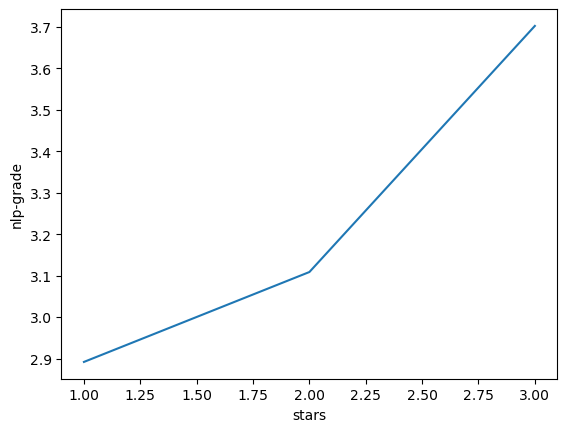

In [125]:
sums=[0,0,0,0,0]
counters = [0,0,0,0,0]
avg=[0,0,0,0,0]
for row in range(df2.shape[0]):
    sums[int(float(df2['stars'][row]))-1]+=df2['nlp-grade'][row]
    counters[int(float(df2['stars'][row]))-1]+=1
for i in range(len(sums)):
    avg[i]=sums[i]/counters[i]
plt.plot([1,2,3,4,5],avg)
plt.ylabel('nlp-grade')
plt.xlabel('stars')
plt.show()


# regression

this next lines are the regression on the dataframe before deleting outliers

In [112]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


y = df['stars']

X = df[['nlp-grade']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Print the model's coefficients and intercept
print(model.coef_)
print(model.intercept_)


[0.5912112]
1.9475192898443376


this next lines are the regression on the dataframe before deleting outliers

In [113]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split




y = df2['stars']

X = df2[['nlp-grade']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(model.coef_)
print(model.intercept_)


[0.8991671]
0.4785788342406603


###### bonus:this is the difference between the stars avg score to the nlp avg score

In [55]:
print( df['stars'].mean())
print( df['nlp-grade'].mean())

4.56617204732304
4.42725520352917


In [57]:
df

,reviews-title,reviews-text,stars,nlp-grade
4995,Holiday,We visited the Empire State Building at night ...,5.0,4.9376
6101,Bucket list item,If you only have a single night in New York th...,5.0,4.8520
6051,First Visit,This was our third trip to Manhattan but our f...,5.0,4.8414
6087,Much improved experience.,Visited back in 2001 and much has changed. Was...,5.0,4.1148
6086,Must see,The most famous building in the world. a must ...,5.0,4.7652
...,...,...,...,...
2041,Corporate Greed,"With a global pandemic & no flights, they stil...",1.0,1.9466
3607,Engaged and first time visit,I had an amazing time at the Empire State Buil...,1.0,4.9532
3601,Dec 19,Over priced to say the least. The cost for a f...,1.0,4.4134
7013,Vsitor blocking half of the access.,almost outrageous... We paid full rate for the...,1.0,3.8526


# מסקנות

###### מהפרוייקט אפשר ללמוד כמה דברים,דבר ראשון הוא שאפשר לבדוק את הניקוד של מקום מסויים רק מהתגובות ולא רק מהכוכבים שמשתמשים נותנים,דבר נוסף הוא שאנשים יותר ביקורתיים באינטרנט לפי הגרפים אפשר לראות שאנשים שנתנו כוכב אחד התגובה הממוצעת קיבלה ציון גבוה (3.0) ודבר אחרון שאפשר לראות זה שאנשים לפעמים סתם מנקדים את הכוכבים לדוגמה בשורה 3607 משתמש סיפר שזאת היתה הפעם הראשונה שלו והוא הציע שם נישואים והיה חוויה מדהימה ועדיין הוא נתן כוכב אחד (כנראה בטעות)